### 0. Importing and loading the data


In [1]:
# importing packages
%matplotlib inline
import json
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statistics
import time
from calendar import monthrange

In [74]:
# importing commit data of bitcoin, numpy, react projects on github
with open('bitcoin_commits.json') as f:
    bitcoin_data = json.load(f)
with open('numpy_commits.json') as f:
    numpy_data = json.load(f)
with open('react_commits.json') as f:
    react_data = json.load(f)

In [75]:
# creating pandas dataframe from the loaded files
b_df = pd.DataFrame(bitcoin_data)
n_df = pd.DataFrame(numpy_data)
r_df = pd.DataFrame(react_data)

### 1. Preprocessing the data
1. change the time from seconds to datetime
2. sort the array by commit time
3. create a field "month"

In [77]:
# 1. Changing the time from seconds to the datetime 
# Run this only once (when first loading the data)
b_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in b_df["committer_time"]]
n_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in n_df["committer_time"]]
r_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in r_df["committer_time"]]

In [78]:
# 2. Sorting by time
n_df = n_df.sort_values(by=['committer_time'])
b_df = b_df.sort_values(by=['committer_time'])
r_df = r_df.sort_values(by=['committer_time'])

In [79]:
# 3. Creating the field "month"
n_df["month"]=[100*i.year+i.month for i in n_df["committer_time"]]
r_df["month"]=[100*i.year+i.month for i in r_df["committer_time"]]
b_df["month"]=[100*i.year+i.month for i in b_df["committer_time"]]

### 2. Preliminary information about the projects

In [81]:
index = ['bitcoin', 'numpy', 'react']
column = ['number of commits', 'number of contributors', 'first date', 'last date']

In [82]:
b_num_commit = b_df.shape[0]
n_num_commit = n_df.shape[0]
r_num_commit = r_df.shape[0]

In [83]:
b_num_cont = len(set(b_df["author_name"]))
n_num_cont = len(set(n_df["author_name"]))
r_num_cont = len(set(r_df["author_name"]))

In [84]:
b_start = b_df['committer_time'][0]
n_start = n_df['committer_time'][0]
r_start = r_df['committer_time'][0]

In [85]:
b_last_list = list(b_df['committer_time'])
b_last_list.sort()
n_last_list = list(n_df['committer_time'])
n_last_list.sort()
r_last_list = list(r_df['committer_time'])
r_last_list.sort()

In [86]:
projects = pd.DataFrame([[b_num_commit,b_num_cont,b_start,b_last_list[-1]],\
                         [n_num_commit,n_num_cont,n_start,b_last_list[-1]],\
                         [r_num_commit,r_num_cont,r_start,b_last_list[-1]]],index=index,columns=column)
projects

,number of commits,number of contributors,first date,last date
bitcoin,36302,1210,2009-08-29 23:46:39,2018-01-18 10:05:40
numpy,24552,937,2001-12-18 10:45:10,2018-01-18 10:05:40
react,24157,2138,2013-05-29 08:54:02,2018-01-18 10:05:40


### 3. Options for picking the dividing point
1. largest number of new contributors
2. largest increase in the number of contributors

In [87]:
def pick_div(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest number of new contributors
    '''
    months = list(set(df['month']))
    months.sort()
    div_month = 0
    largest = 0
    old_users = set()
    for i in months:
        is_month_i = df[df["month"]==i]
        curr_month_users = set(is_month_i["committer_name_dedup"])
        new_users = curr_month_users - old_users
        old_users = old_users.union(new_users)
        if len(new_users) > largest:
            largest = len(new_users)
            div_month = i
        prev_month = len(curr_month_users)
    return div_month

In [88]:
def pick_div2(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest increase in the number of contributors
    '''
    months = list(set(df['month']))
    months.sort()
    prev_month = 0
    div_month = 0
    largest_jump = 0
    for i in months:
        is_month_i = df[df["month"]==i]
        diff = len(set(is_month_i["committer_name_dedup"])) - prev_month
        if diff > largest_jump:
            largest_jump = diff
            div_month = i
        prev_month = len(set(is_month_i["committer_name_dedup"]))
    return div_month

In [89]:
print("Numpy's diving point using the first method of picking the dividing point is {}".format(pick_div(n_df)))
print("Numpy's diving point using the second method of picking the dividing point is {}".format(pick_div2(n_df)))
print("React's diving point using the first method of picking the dividing point is {}".format(pick_div(r_df)))
print("React's diving point using the second of picking the dividing point is {}".format(pick_div2(r_df)))
print("Bitcoin's diving point using the first method of picking the dividing point is {}".format(pick_div(b_df)))
print("Bitcoin's diving point using the second of picking the dividing point is {}".format(pick_div2(b_df)))

Numpy's diving point using the first method of picking the dividing point is 201601
Numpy's diving point using the second method of picking the dividing point is 201510
React's diving point using the first method of picking the dividing point is 201510
React's diving point using the second of picking the dividing point is 201510
Bitcoin's diving point using the first method of picking the dividing point is 201403
Bitcoin's diving point using the second of picking the dividing point is 201403


##### Findings
1. Looks like the two methods are returning almost identical month proving that they are good identifier of the dividing point

### 4. Visualizing the dividing point

In [90]:
def vis_div(df, title):
    '''
    visualize the dividing point
    '''
    months = set(df['month'])
    months = list(months)
    months.sort()
    month_dict = {}
    for i in months:
        is_month_i = df[df["month"]==i]
        month_dict[i]=len(set(is_month_i["committer_name_dedup"]))
    plt.ylabel('Number of contributors')
    plt.xlabel('YearMonth')
    plt.title(title)
    plt.scatter(list(month_dict.keys()),list(month_dict.values()))
    plt.show()

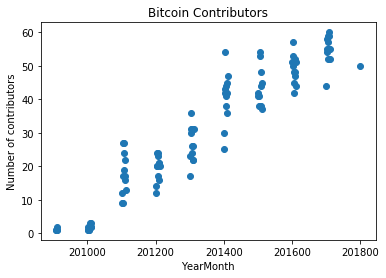

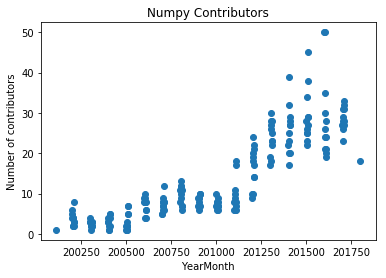

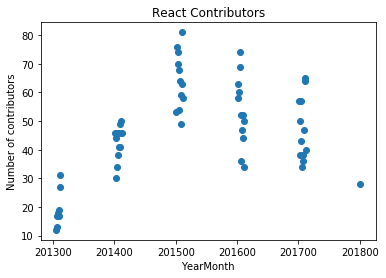

In [18]:
vis_div(bitcoin_df, "Bitcoin Contributors")
vis_div(numpy_df, "Numpy Contributors")
vis_div(react_df, "React Contributors")

### 5. Find the old users

In [19]:
def old_users(df):
    '''
    return the Pandas dataframe of commits done only by the old users
    '''
    div = pick_div(df)
    s = set(df['author_name'])
    old_users = []
    for a in s:
        a_df = df[df['author_name'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        first = a_commit_time_list[0]
        first = str(first.year) + '' + str(first.month) if first.month >= 10 else str(first.year) + '0' + str(first.month)
        if int(first) >= div:
            continue
        old_users.append(a)
    return df[df['author_name'].isin(old_users)]

In [92]:
n_old = old_users(n_df)
r_old = old_users(r_df)
b_old = old_users(b_df)

In [93]:
print("Numpy's number of old users is {}".format(len(set(n_old['author_name']))))
print("React's number of old users is {}".format(len(set(r_old['author_name']))))
print("Bitcoin's number of old users is {}".format(len(set(b_old['author_name']))))

Numpy's number of old users is 597
React's number of old users is 826
Bitcoin's number of old users is 352


### 6. How long do the older users stick around?

In [22]:
def stick_around(df):
    '''
    return 1. the median start date of the old user 
           2. the median last date of the old user
    in 2-tuple form (1, 2)
    '''
    div = pick_div(df)
    s = set(df['author_name'])
    n_div = pick_div(df)
    firsts = []
    lasts = []
    for a in s:
        a_df = df[df['author_name'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        first = a_commit_time_list[0]
        first_div_format = str(first.year) + '' + str(first.month) if first.month >= 10 else str(first.year) + '0' + str(first.month)
        if int(first_div_format) >= n_div:
            continue
        last  = a_commit_time_list[-1]
        first_int = int(time.mktime(first.timetuple()))
        last_int = int(time.mktime(last.timetuple()))
        firsts.append(first_int)
        lasts.append(last_int)
    first_med = statistics.median(firsts)
    last_med = statistics.median(lasts)
    return (datetime.datetime.fromtimestamp(first_med), datetime.datetime.fromtimestamp(last_med))


In [94]:
r_median_time = stick_around(r_df)
n_median_time = stick_around(n_df)
b_median_time = stick_around(b_df)

print("The median time React contributors stuck around is between %s and %s" % r_median_time)
print("The median time Numpy contributors stuck around is between %s and %s" % n_median_time)
print("The median time Bitcoin contributors stuck around is between %s and %s" % b_median_time)

The median time React contributors stuck around is between 2014-11-30 22:17:50.500000 and 2015-02-07 10:38:01
The median time Numpy contributors stuck around is between 2014-01-05 11:25:25 and 2014-07-23 15:03:14
The median time Bitcoin contributors stuck around is between 2012-10-24 03:04:41.500000 and 2013-03-28 15:51:47


In [95]:
def old_before_div(df):
    '''
    Returns the dataframe containing the commits by the old users before the dividing point
    '''
    div = pick_div(df)
    div_year = int(str(div)[:4])
    div_month = int(str(div)[-2:])
    div_day = monthrange(div_year, div_month)[1]
    div = datetime.datetime(div_year, div_month, div_day)
    old_df = old_users(df)
    after_div_df = old_df[old_df['committer_time'] <= div]
    return after_div_df

In [96]:
def old_after_div(df):
    '''
    Returns the dataframe containing the commits by the old users after the dividing point
    '''
    div = pick_div(df)
    div_year = int(str(div)[:4])
    div_month = int(str(div)[-2:])
    div_day = monthrange(div_year, div_month)[1]
    div = datetime.datetime(div_year, div_month, div_day)
    old_df = old_users(df)
    after_div_df = old_df[old_df['committer_time'] > div]
    return after_div_df

In [97]:
n_old_bef = old_before_div(n_df)
r_old_bef = old_before_div(r_df)
b_old_bef = old_before_div(b_df)
n_old_aft = old_after_div(n_df)
r_old_aft = old_after_div(r_df)
b_old_aft = old_after_div(b_df)

In [108]:
# These guys are the old contributors
n_old = set(n_old_bef['author_name'])
r_old = set(r_old_bef['author_name'])
b_old = set(b_old_bef['author_name'])
# These guys are the survivors.
n_surv = set(n_old_aft['author_name'])
r_surv = set(r_old_aft['author_name'])
b_surv = set(b_old_aft['author_name'])
# These guys are the non survivors.
n_nonsurv = n_old - n_surv
r_nonsurv = r_old - r_surv
b_nonsurv = b_old - b_surv
print("Number of old contributors")
print("Numpy: {}".format(len(n_old)))
print("React: {}".format(len(r_old)))
print("Bitcoin: {}\n".format(len(b_old)))

print("Number of survivors")
print("Numpy: {}".format(len(n_surv)))
print("React: {}".format(len(r_surv)))
print("Bitcoin: {}\n".format(len(b_surv)))

print("Number of non-survivors")
print("Numpy: {}".format(len(n_nonsurv)))
print("React: {}".format(len(r_nonsurv)))
print("Bitcoin: {}".format(len(b_nonsurv)))

Number of old contributors
Numpy: 597
React: 826
Bitcoin: 352

Number of survivors
Numpy: 128
React: 94
Bitcoin: 61

Number of non-survivors
Numpy: 469
React: 732
Bitcoin: 291


##### Findings
1. Seems like most old contributors leave the project before the project becomes popular! 128 out of 597 from Numpy, 94 out of 826 from React, and 61 out of 352 from Bitcoin survived!

### 7. How did old contributors' behaviour change from before the div point ?
1. We will take only the old users who kept contributing after the div point (SURVIVORS from now on) to analyze their behaviour

In [101]:
# These dataframes contain commits by the survivors
n_old_bef_surv = n_old_bef[n_old_bef['author_name'].isin(n_surv)]
r_old_bef_surv = r_old_bef[r_old_bef['author_name'].isin(r_surv)]
b_old_bef_surv = b_old_bef[b_old_bef['author_name'].isin(b_surv)]

In [102]:
# Array to be used as the heights of the first bar chart below. 
num_commits_array = []
num_commits_array.append(len(n_old_bef_surv))
num_commits_array.append(len(n_old_aft))
num_commits_array.append(len(r_old_bef_surv))
num_commits_array.append(len(r_old_aft))
num_commits_array.append(len(b_old_bef_surv))
num_commits_array.append(len(b_old_aft))

<BarContainer object of 6 artists>

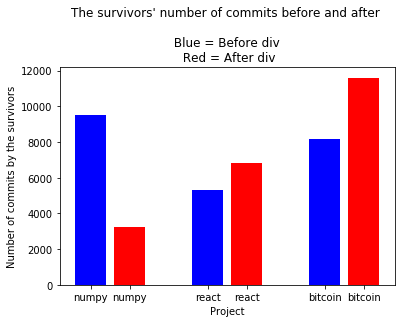

In [109]:
plt.ylabel('Number of commits by the survivors')
plt.xlabel('Project')
plt.title("The survivors' number of commits before and after \n\n Blue = Before div \n Red = After div")
plt.bar(x=[1, 2, 4, 5 ,7 ,8], \
        height=num_commits_array, \
        color=['blue','red','blue','red','blue','red'], \
        tick_label=['numpy', 'numpy', 'react', 'react', 'bitcoin', 'bitcoin'])

In [116]:
# Array to be used as the heights of the second bar chart below. 
num_commits_array_2 = []
num_commits_array_2.append((len(n_old_bef) - len(n_old_bef_surv)) / len(n_nonsurv))
num_commits_array_2.append(len(n_old_bef_surv) / len(n_surv))
num_commits_array_2.append((len(r_old_bef) - len(r_old_bef_surv)) / len(r_nonsurv))
num_commits_array_2.append(len(r_old_bef_surv) / len(r_surv))
num_commits_array_2.append((len(b_old_bef) - len(b_old_bef_surv)) / len(b_nonsurv))
num_commits_array_2.append(len(b_old_bef_surv) / len(b_surv))

<BarContainer object of 6 artists>

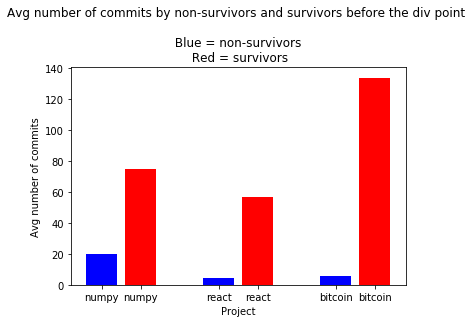

In [117]:
plt.ylabel('Avg number of commits')
plt.xlabel('Project')
plt.title('Avg number of commits by non-survivors and survivors before the div point \n\n Blue = non-survivors \n Red = survivors')
plt.bar(x=[1, 2, 4, 5 ,7 ,8], \
        height=num_commits_array_2, \
        color=['blue','red','blue','red','blue','red'], \
        tick_label=['numpy', 'numpy', 'react', 'react', 'bitcoin', 'bitcoin'])

##### Findings
1. (From first bar chart) couldn't find a uniform pattern on the change of survivors' number of commit after the div point. (numpy survivors contributed less, but for the other two projects, the survivors started contributing more)
2. (From second bar chart) we FOUND that the survivors contributed a lot more to the projects compared to the non-survivors. 

In [33]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

NameError: name 'lists' is not defined

In [70]:
import collections

In [71]:
collections.OrderedDict

collections.OrderedDict

In [63]:
numpy_df[numpy_df['month'] == "2001-12"]

,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,committer_name_dedup,...,delay,id,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof,month
0,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-18 10:45:10,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,f1a2d6376c430f65550efa235209b86c1a0967e3,False,0,1337,factored out the scipy specific distutils code...,1,14,-1,2001-12
1,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:03:41,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,74a4958b94e07b2e3218741fb52d32e87308d62e,False,0,303,split scipy_test off into its own module.\n,1,3,-1,2001-12
2,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:05:32,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,a76efe8206df0ec315f67012236577c1e31ad258,False,1,29,added build_py module\n,1,3,-1,2001-12
3,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:06:40,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,76cfe839f027edd48a86112bc8e1490d848d20d0,False,37,102,added misc_util file that has a few routines u...,1,5,-1,2001-12
4,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:40:02,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,b1263a71669aad6b9ac5db8ce961a18c204e925f,False,1,128,fixed path issues resulting from using setup_x...,1,2,-1,2001-12
5,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:52:45,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,806417f9f8b3c3a2414362b0ee69684a7afe58cb,False,0,14,added package_config method to misc_util that ...,1,1,-1,2001-12
6,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:54:57,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,8d4cc5e1967f6b20e69158e5a2700aecc50d46e2,False,1,1,added default setting so users don't need to s...,1,1,-1,2001-12
7,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 04:13:38,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,d1d33442a918c2ec4b90dc5f777397e021cd10d1,False,6,0,removed print statements\n,1,1,-1,2001-12


In [ ]:
# read the entire file into a python array
with open('C:/Users/Alberto/nutrients.json', 'rb') as f:
   data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ",".join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)